In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

In [2]:
def gauss(x, sigma):
    """Compute Gaussian with amplitude of 1."""
    return np.exp(-x**2 / 2 / sigma**2)

def asymmetric_gauss(x, sigma1, sigma2):
    """Compute asymmetric Gaussian with amplitude of 1."""
    data = np.zeros(np.size(x))
    data[x>=0] = gauss(x[x>=0], sigma1)
    data[x<0] = gauss(x[x<0], sigma2)
    return data

## Quickly Test the Current Profile and CRISP Data Generation

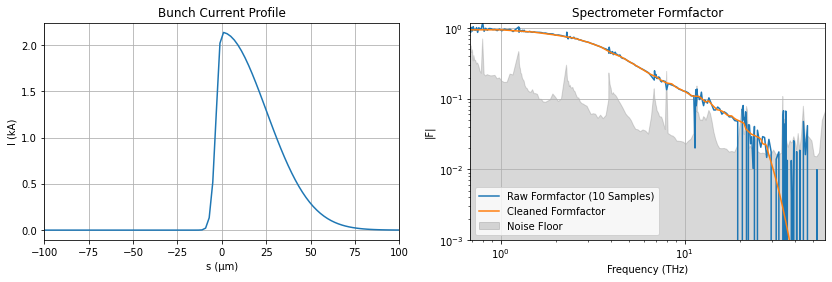

In [3]:
s = np.linspace(-100e-6, 100e-6, 100)
profile = asymmetric_gauss(s, 25e-6, 3e-6)
charge = 250e-12

current = profile / np.trapz(profile, x=s/3e8) * charge

frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set="both")
clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Bunch Current Profile")
plt.plot(s*1e6, current*1e-3)
plt.xlim([s.min()*1e6, s.max()*1e6])
plt.xlabel("s (µm)")
plt.ylabel("I (kA)")
plt.grid()
plt.subplot(122)
plt.title("Spectrometer Formfactor")
plt.plot(frequency*1e-12, formfactor, label="Raw Formfactor (10 Samples)")
plt.fill_between(frequency*1e-12, np.zeros_like(detlim), y2=detlim, label="Noise Floor", alpha=0.3, color="gray")
plt.plot(clean_frequency*1e-12, clean_formfactor, label="Cleaned Formfactor")
plt.xlim([frequency.min()*1e-12, frequency.max()*1e-12])
plt.ylim([1e-3, 1.2])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (THz)")
plt.ylabel("|F|")
plt.legend()
plt.grid()
plt.show()

## Generate Training Data

In [4]:
def make_random_current():
    """Generate a random current profile."""
    s = np.linspace(-100e-6, 100e-6, 100)
    charge = 250e-12

    sigma1 = np.random.uniform(25e-6, 3e-6)
    sigma2 = np.random.uniform(25e-6, 3e-6)

    profile = asymmetric_gauss(s, sigma1,sigma2)
    current = profile / np.trapz(profile, x=s/3e8) * charge

    return s, current

In [5]:
def current2formfactor(s, current):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set="both")
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

In [6]:
n_samples = 1000

currents = [make_random_current() for _ in range(n_samples)]
formfactors = [current2formfactor(*current) for current in currents]

In [7]:
X = np.stack([formfactor for _, formfactor in formfactors])
y = np.stack([current for _, current in currents])

## Training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
ff_scaler = MinMaxScaler()
X_train_scaled = ff_scaler.fit_transform(X_train)

current_scaler = 1 / y_train.max(axis=1).mean()
y_train_scaled = y_train * current_scaler

In [10]:
model = keras.Sequential([layers.Dense(200, activation="relu"),
                          layers.Dense(100, activation="relu"),
                          layers.Dense(50, activation="relu"),
                          layers.Dense(y_train.shape[1])])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [11]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, validation_split=0.25)

Epoch 1/100
10/10 [==============================] - 1s 28ms/step - loss: 0.0970 - mae: 0.1721 - val_loss: 0.0783 - val_mae: 0.1757
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0640 - mae: 0.1641 - val_loss: 0.0460 - val_mae: 0.1381
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0349 - mae: 0.1197 - val_loss: 0.0252 - val_mae: 0.0991
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0201 - mae: 0.0878 - val_loss: 0.0173 - val_mae: 0.0790
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0151 - mae: 0.0745 - val_loss: 0.0150 - val_mae: 0.0730
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0137 - mae: 0.0710 - val_loss: 0.0144 - val_mae: 0.0719
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0131 - mae: 0.0684 - val_loss: 0.0133 - val_mae: 0.0674
Epoch 8/100
10/10 [==============================] - 0s 8ms/step - loss: 0.012

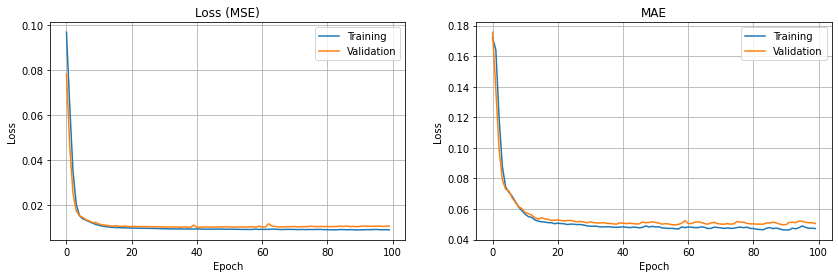

In [12]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title("Loss (MSE)")
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.subplot(122)
plt.title("MAE")
plt.plot(history.history["mae"], label="Training")
plt.plot(history.history["val_mae"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## Quick Test

In [13]:
X_test_scaled = ff_scaler.transform(X_test)
y_predict_scaled = model.predict(X_test_scaled)
y_predict = y_predict_scaled / current_scaler

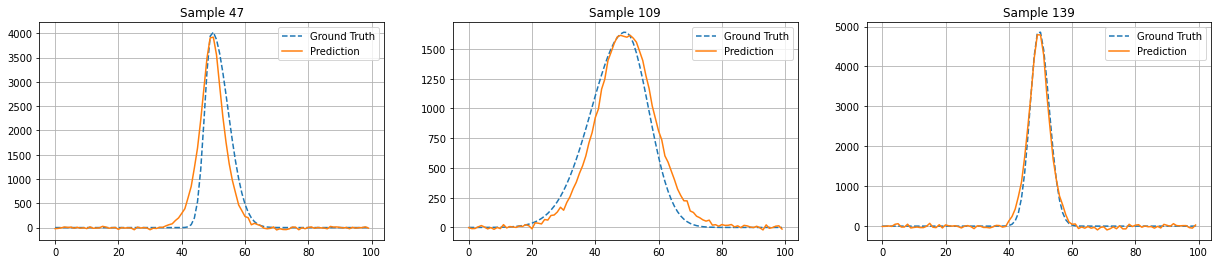

In [19]:
samples = np.random.randint(0, len(y_predict), size=3)

plt.figure(figsize=(21,4))
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(new_s, y_test[sample], ls="--", label="Ground Truth")
    plt.plot(new_s, y_predict[sample], label="Prediction")
    plt.legend()
    plt.grid()
plt.show()

## Evaluation

In [20]:
X_test_scaled = ff_scaler.transform(X_test)
y_test_scaled = y_test * current_scaler

In [21]:
score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

4/4 [==============================] - 0s 3ms/step - loss: 0.0095 - mae: 0.0471
